In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, LSTM, TimeDistributed
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.layers import Lambda, Input, Dense

from keras.models import Model, Sequential
from keras.losses import mse, binary_crossentropy
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

from keras import backend as K

Using TensorFlow backend.


In [2]:
class LaserScans:
    def __init__(self, datafile, clip_scans_at=8, scan_bound_percentage=0.15, verbose=False):
        self.verbose = verbose
        self.data = np.loadtxt(datafile).astype('float32')
        self.clip_scans_at = clip_scans_at
        self.scan_bound_percentage = scan_bound_percentage
        self.timesteps = self.data[:, :1]
        self.cmd_vel = self.data[:, 1:7]
        self.scans = self.data[:, 7:]
        
        if self.verbose: 
            print("timesteps --", self.timesteps.shape)
            print("cmd_vel --", self.cmd_vel.shape)
            print("scans --", self.scans.shape, "ranges [", np.max(self.scans), "-", np.min(self.scans), "]")
            
        np.clip(self.scans, a_min=0, a_max=clip_scans_at, out=self.scans)
        
        # bounds are due to the embodiment of the particular robot used, this should not exist!!!
        min_bound = int(self.scan_bound_percentage*self.scans.shape[1])
        max_bound = int(self.scans.shape[1] - self.scan_bound_percentage*self.scans.shape[1])
        if self.verbose: print("scans bounds (min, max)=", min_bound, max_bound)
        
        self.scans = self.scans[:, min_bound:max_bound] / self.clip_scans_at    # normalization makes the vae work
    
    def originalScansDim(self):
        return self.scans.shape[1]
    
    def timesteps(self):
        return self.timesteps
    
    def cmdVel(self):
        return self.cmd_vel
    
    def getScans(self, split_at=0):
        if split_at == 0: return self.scans
        
        x_train = self.scans[:int(self.scans.shape[0]*split_at),:]
        x_test = self.scans[int(self.scans.shape[0]*split_at):,:]
        
        if self.verbose:
            print("scans train:", x_train.shape)
            print("scans test:", x_test.shape)
            
        return x_train, x_test
    
    def getScanSegments(self, scan, threshold):
        segments = []
        iseg = 0
        useg = bool(scan[0] > threshold)
        for d in range(scan.shape[0]):
            if useg and scan[d] < threshold:
                segments.append([iseg, d, useg])
                iseg = d
                useg = False
            if not useg and scan[d] > threshold:
                segments.append([iseg, d, useg])
                iseg = d
                useg = True
            if d == scan.shape[0] - 1: segments.append([iseg, d, useg])
        return segments
    
    def plotScan(self, scan, y=None):
        lstep = (3/2)*np.pi/720
        theta = np.arange(self.scan_bound_percentage*(3/2)*np.pi, 
                          (1 - self.scan_bound_percentage)*(3/2)*np.pi, lstep) - self.scan_bound_percentage*(3/2)*np.pi
        theta = theta[::-1]

        x_axis = np.arange(scan.shape[0])
        segments = self.getScanSegments(scan, 0.99)
        if self.verbose: print("Segments -- ", np.array(segments).shape, "--", segments)

        plt.figure(figsize=(15, 5))
        plt.subplot(121)
        y_axis = scan
        if y != None: y_axis = y

        plt.plot(x_axis, scan, color='lightgray')
        for s in segments:
            if s[2]: 
                col = '#ff7f0e'
                plt.plot(x_axis[s[0]:s[1]], y_axis[s[0]:s[1]], 'o', markersize=0.5, color=col)
            else:
                col = '#1f77b4'
                plt.plot(x_axis[s[0]:s[1]], scan[s[0]:s[1]], 'o', markersize=0.5, color=col)

        plt.subplot(122, projection='polar')
        plt.plot(theta, scan, color='lightgray')
        for s in segments:
            if s[2]: 
                col = '#ff7f0e'
                plt.plot(theta[s[0]:s[1]], y_axis[s[0]:s[1]], 'o', markersize=0.5, color=col)
            else:
                col = '#1f77b4'
                plt.plot(theta[s[0]:s[1]], scan[s[0]:s[1]], 'o', markersize=0.5, color=col)

In [3]:
class VAE:
    def __init__(self, batch_size=128, latent_dim=10, intermediate_dim=128, verbose=False):
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.verbose = verbose

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    def buildModel(self, original_dim):
        input_shape = (original_dim, )

        # VAE model = encoder + decoder
        # build encoder model
        inputs = Input(shape=input_shape, name='encoder_input')
        x = Dense(self.intermediate_dim, activation='relu')(inputs)
        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        # instantiate encoder model
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        if self.verbose: encoder.summary()

        # build decoder model
        latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
        x = Dense(self.intermediate_dim, activation='relu')(latent_inputs)
        outputs = Dense(original_dim, activation='sigmoid')(x)

        # instantiate decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        if self.verbose: decoder.summary()

        # instantiate VAE model
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')
        
        reconstruction_loss = binary_crossentropy(inputs, outputs)
        reconstruction_loss *= original_dim
        
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        
        self.vae.add_loss(vae_loss)
        self.vae.compile(optimizer='adam')
        if self.verbose: self.vae.summary()
    
    def fitModel(self, x, x_test=None, epochs=10, verbose=None):
        if x_test is None:
            self.vae.fit(x,
                         epochs=epochs,
                         batch_size=self.batch_size,
                         verbose=verbose)
        else:
            self.vae.fit(x,
                         epochs=epochs,
                         batch_size=self.batch_size,
                         verbose=verbose,
                         validation_data=(x_test, None))
    
    def predictEncoder(self, x, batch_size=None):
        if len(x.shape) == 1: x = np.array([x])
        z_mean, _, _ = self.encoder.predict(x, batch_size=batch_size)
        return z_mean
    
    def predictDecoder(self, z_mean):
        x_decoded = self.decoder.predict(z_mean)
        return x_decoded

In [4]:
class GAN:
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.D = None   # discriminator
        self.G = None   # generator
        self.RG = None  # recurrent generator
        self.DM = None  # discriminator model
        self.AM = None  # adversarial model
        self.RAM = None  # recurrent adversarial model
        
    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D: return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        self.D.add(Conv2D(depth*1, 5, strides=2, 
                          input_shape=self.input_shape, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        if self.verbose: self.D.summary()
        return self.D

    def generator(self):
        if self.G: return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 16
        
        self.G.add(Dense(dim*depth, input_dim=self.latent_input))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, 1, depth)))
        self.G.add(Dropout(dropout))

        self.G.add(UpSampling2D(size=(2, 1)))
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D(size=(4, 1)))
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D(size=(2, 1)))
        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D(size=(2, 1)))
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        if self.verbose: self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM: return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', 
                        optimizer=optimizer, metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM: return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', 
                        optimizer=optimizer, metrics=['accuracy'])
        return self.AM
    
    def buildModel(self, original_dim, latent_input, recurrent_generator=False):
        self.latent_input = latent_input  
        self.input_shape = (original_dim + 8, 1, 1,)  # 504 + 8
        self.DIS = self.discriminator_model()
        
        if recurrent_generator:
            pass
            # self.GEN = self.recurrent_generator()
            # self.ADV = self.recurrent_adversarial_model()
        else:
            self.GEN = self.generator()
            self.ADV = self.adversarial_model()
            
    def fitModel(self, x, x_label, train_steps=10, batch_size=16, verbose=None):
        for i in range(train_steps):
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.latent_input])
            
            real = np.zeros((batch_size, self.input_shape[0], 1, 1))
            real[:,:x_label.shape[1], 0, 0] = x_label
            fake = self.GEN.predict(x)
    
            x_train = np.concatenate((real, fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.DIS.train_on_batch(x_train, y)
            
            y = np.ones([batch_size, 1])
            a_loss = self.ADV.train_on_batch(x, y)
            
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            if self.verbose: print(log_mesg)
                
    def generate(self, x):
        return self.GEN.predict(x)[:, :, 0, 0]

In [5]:
if __name__ == "__main__":
    # DIAG_first_floor.txt 
    # diag_labrococo.txt
    # diag_underground.txt
    ls = LaserScans("../../dataset/diag_underground.txt", verbose=True)

timesteps -- (13545, 1)
cmd_vel -- (13545, 6)
scans -- (13545, 721) ranges [ 30.0 - 0.0 ]
scans bounds (min, max)= 108 612


In [6]:
    vae = VAE()
    vae.buildModel(ls.originalScansDim())
    vae.fitModel(ls.getScans(), epochs=10, verbose=0)
    
    x, x_test = ls.getScans(0.9)
    vae.fitModel(x, x_test=x_test)

scans train: (12190, 504)
scans test: (1355, 504)


Segments --  (5, 3) -- [[0, 159, False], [159, 228, True], [228, 243, False], [243, 246, True], [246, 503, False]]


/home/sapienzbot/.local/lib/python3.5/site-packages/ipykernel_launcher.py:75: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


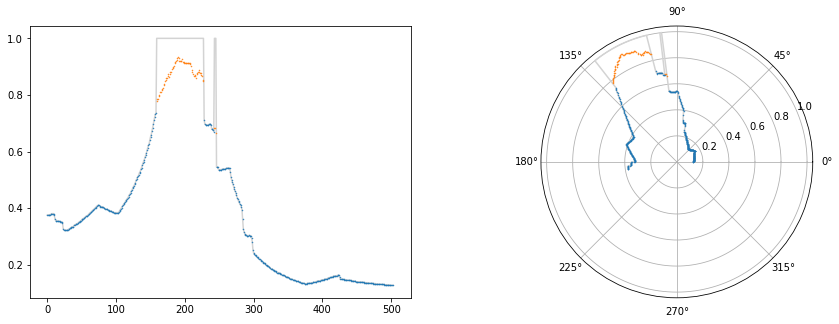

In [7]:
    gan_batch_sz = 16
    scan_idx = 1000
    scan = x[scan_idx:(scan_idx + gan_batch_sz)]
    z_latent = vae.predictEncoder(scan)
    dscan = vae.predictDecoder(z_latent)
    ls.plotScan(scan[0], dscan[0])

In [8]:
    gan = GAN(verbose=False) 
    gan.buildModel(ls.originalScansDim(), 10 + 6, # latent input dim from vae
                   recurrent_generator=False)

In [9]:
    next_scan = x[(scan_idx + gan_batch_sz):(scan_idx + 2*gan_batch_sz)]
    x_latent = np.concatenate((z_latent, ls.cmdVel()[scan_idx:(scan_idx + gan_batch_sz)]), axis=1)
    gan.fitModel(x_latent, next_scan, train_steps=10, batch_size=gan_batch_sz)

(16, 512)
Segments --  (1, 3) -- [[0, 503, False]]
Segments --  (3, 3) -- [[0, 177, False], [177, 248, True], [248, 503, False]]


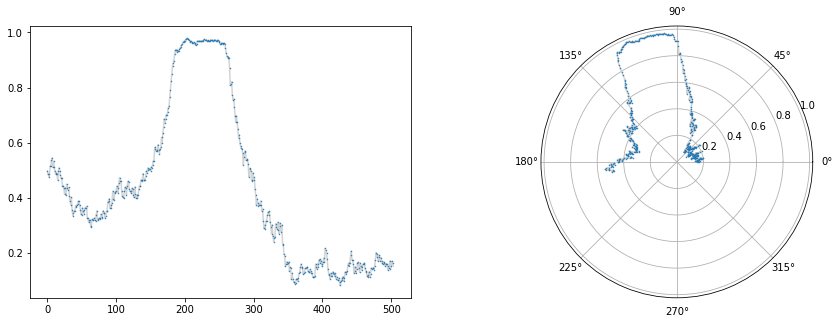

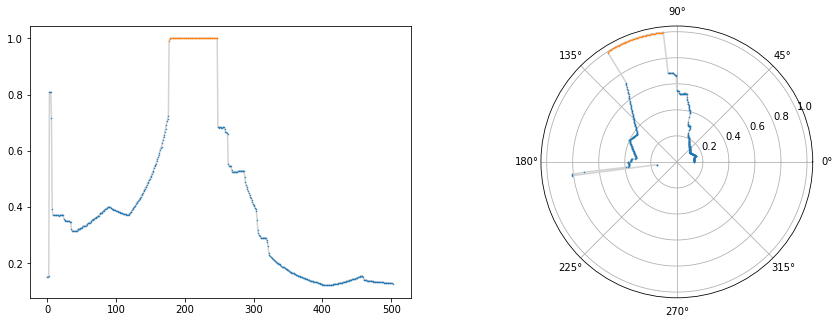

In [10]:
    gscan = gan.generate(x_latent)
    ls.plotScan(gscan[0, :504])
    ls.plotScan(next_scan[0])